In [1]:
import re
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import chi2
from sklearn.metrics import accuracy_score, classification_report

from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer

from nltk.corpus import stopwords

from keras.utils import np_utils
from keras.models import Sequential
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Flatten, LSTM, Conv1D, MaxPooling1D, Dropout, Activation
from keras.layers.embeddings import Embedding


Using TensorFlow backend.


# TF-IDF 

In the first coding test, unigram and bigram were generated from all text data, ignoring the categories. However, the most common words would be different for each category, and it would be possible to predict which category a news article belongs to using these words. 

Seven unigrams and bigrams with the highest frequencies in each category were found using the TF-IDF technique.

In [2]:
df = pd.read_json('News_Category_Dataset.json', lines=True)

# integrat these into "WORLDPOST" since "WORLDPOST" and "THE WORLDPOST" are the same category
df.category = df.category.map(lambda x: "WORLDPOST" if x == "THE WORLDPOST" else x)

# generate text column using headline and short_description columns
df['text'] = df.headline + " " + df.short_description

# convert categories into integers
df['category_idx'] = df.category.factorize()[0]  

X, Y = df.text, df.category_idx

# generate TF-IDF vector with unigram and bigram, minimum length of text data is 5
# remove stop words
tfidf = TfidfVectorizer(min_df=5, ngram_range=(1, 2), stop_words='english')
features = tfidf.fit_transform(X)
labels = Y

N = 7
category_idx_df = df[['category', 'category_idx']].drop_duplicates().sort_values('category_idx')
category_to_idx = dict(category_idx_df.values)

# create unigrams and bigrams for categories
for category, category_idx in sorted(category_to_idx.items()):
    features_chi2 = chi2(features, labels == category_idx)
    indices = np.argsort(features_chi2[0])
    feature_names = np.array(tfidf.get_feature_names())[indices]
    unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
    bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
    print("## {} ##".format(category))
    print("# Most important unigrams:\n. {}".format('\n. '.join(unigrams[-N:])))
    print("# Most important bigrams:\n. {}".format('\n. '.join(bigrams[-N:])))
    

## ARTS ##
# Most important unigrams:
. exhibition
. imageblog
. artist
. theatre
. nighter
. opera
. art
# Most important bigrams:
. jeff koons
. andy warhol
. street artists
. art world
. art fair
. contemporary art
. stage door
## ARTS & CULTURE ##
# Most important unigrams:
. atwood
. rowling
. books
. artists
. book
. artist
. art
# Most important bigrams:
. national book
. lin manuel
. handmaid tale
. women artists
. simon schuster
. merriam webster
. margaret atwood
## BLACK VOICES ##
# Most important unigrams:
. racism
. police
. duvernay
. rapper
. racial
. panther
. black
# Most important bigrams:
. black man
. black people
. black panther
. black men
. lives matter
. black lives
. black women
## BUSINESS ##
# Most important unigrams:
. tesla
. company
. companies
. uber
. ceo
. marketing
. business
# Most important bigrams:
. 000 jobs
. black friday
. elon musk
. nonprofit board
. content marketing
. founder ceo
. women business
## COLLEGE ##
# Most important unigrams:
. fra

# Imbalanced Data
We can see that the number of news categories is imbalanced. Categories are more biased towards Politics and Entertainment.

Conventional algorithms are often biased towards majority class(es), not taking the data distribution into consideration. In the worst case, minority classes are treated as outliers and ignored. Hence, it is desirable to have a classifier that gives high prediction accuracy over the majority class, while maintaining reasonable accuracy for the minority classes. 

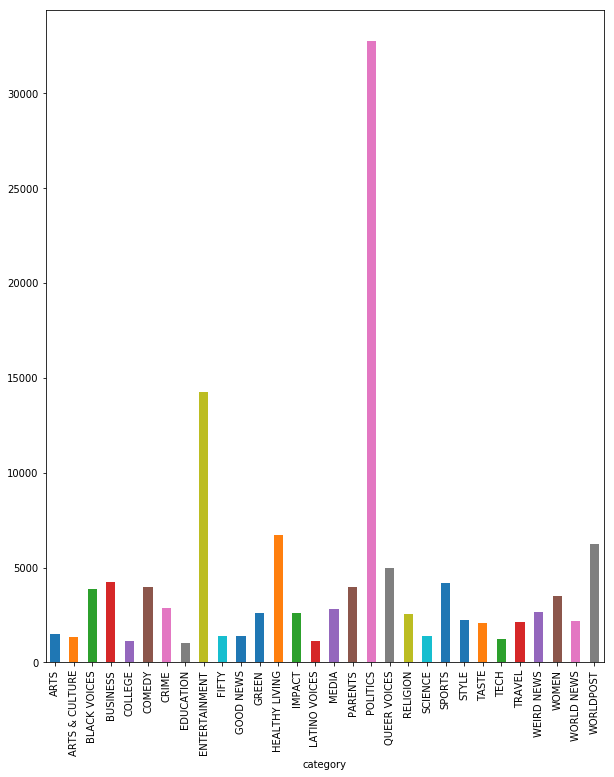

In [3]:
# show majority classes and minority classes

plt.figure(figsize=(10, 12))
df.groupby('category').text.count().plot.bar()
plt.show()

# Accuracy of each machine learning classifier 

Using TF-IDF and machine learning classifiers, we will see which machine learning methods classify the imbalanced data correctly using confusion matrix, classification report (precision, recall, f1-score, support) and accuracy. The machine learning models used are SVM (lineare SVC), logistic regression, and Naive Bayes models.



In [4]:
# train features using unigram and bigram generated by TF-IDF 
count_vectorizer = CountVectorizer(ngram_range=(1, 2), stop_words = 'english')
count_vectorizer.fit_transform(X)
freq_term_matrix = count_vectorizer.transform(X)
tfidf = TfidfTransformer(norm='l2')
features = tfidf.fit_transform(freq_term_matrix)
labels = Y

# split into train and test datasets
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.3, random_state=0)

In [5]:
def normalized_cm_report(model, df, X_train, X_test, y_train, y_test):
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    cats = df.category.unique()

    from sklearn.metrics import confusion_matrix
    
    # nomalize confusion matrix
    cm = confusion_matrix(y_test, y_pred)     
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    # plot nomalized confusion matrix
    plt.subplots(figsize=(25, 25))
    sns.heatmap(cm, annot=True, fmt='.4f', cmap="YlGnBu", xticklabels = cats, yticklabels = cats)

    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

    print()

    # classification report: precision, recall, f1-score, support and accuracy
    print(classification_report(y_test, y_pred, target_names = cats))
    print("Prediction Accuracy on Test Data:", accuracy_score(y_test, y_pred))
    
    

### Support Vector Classifier with TF-IDF

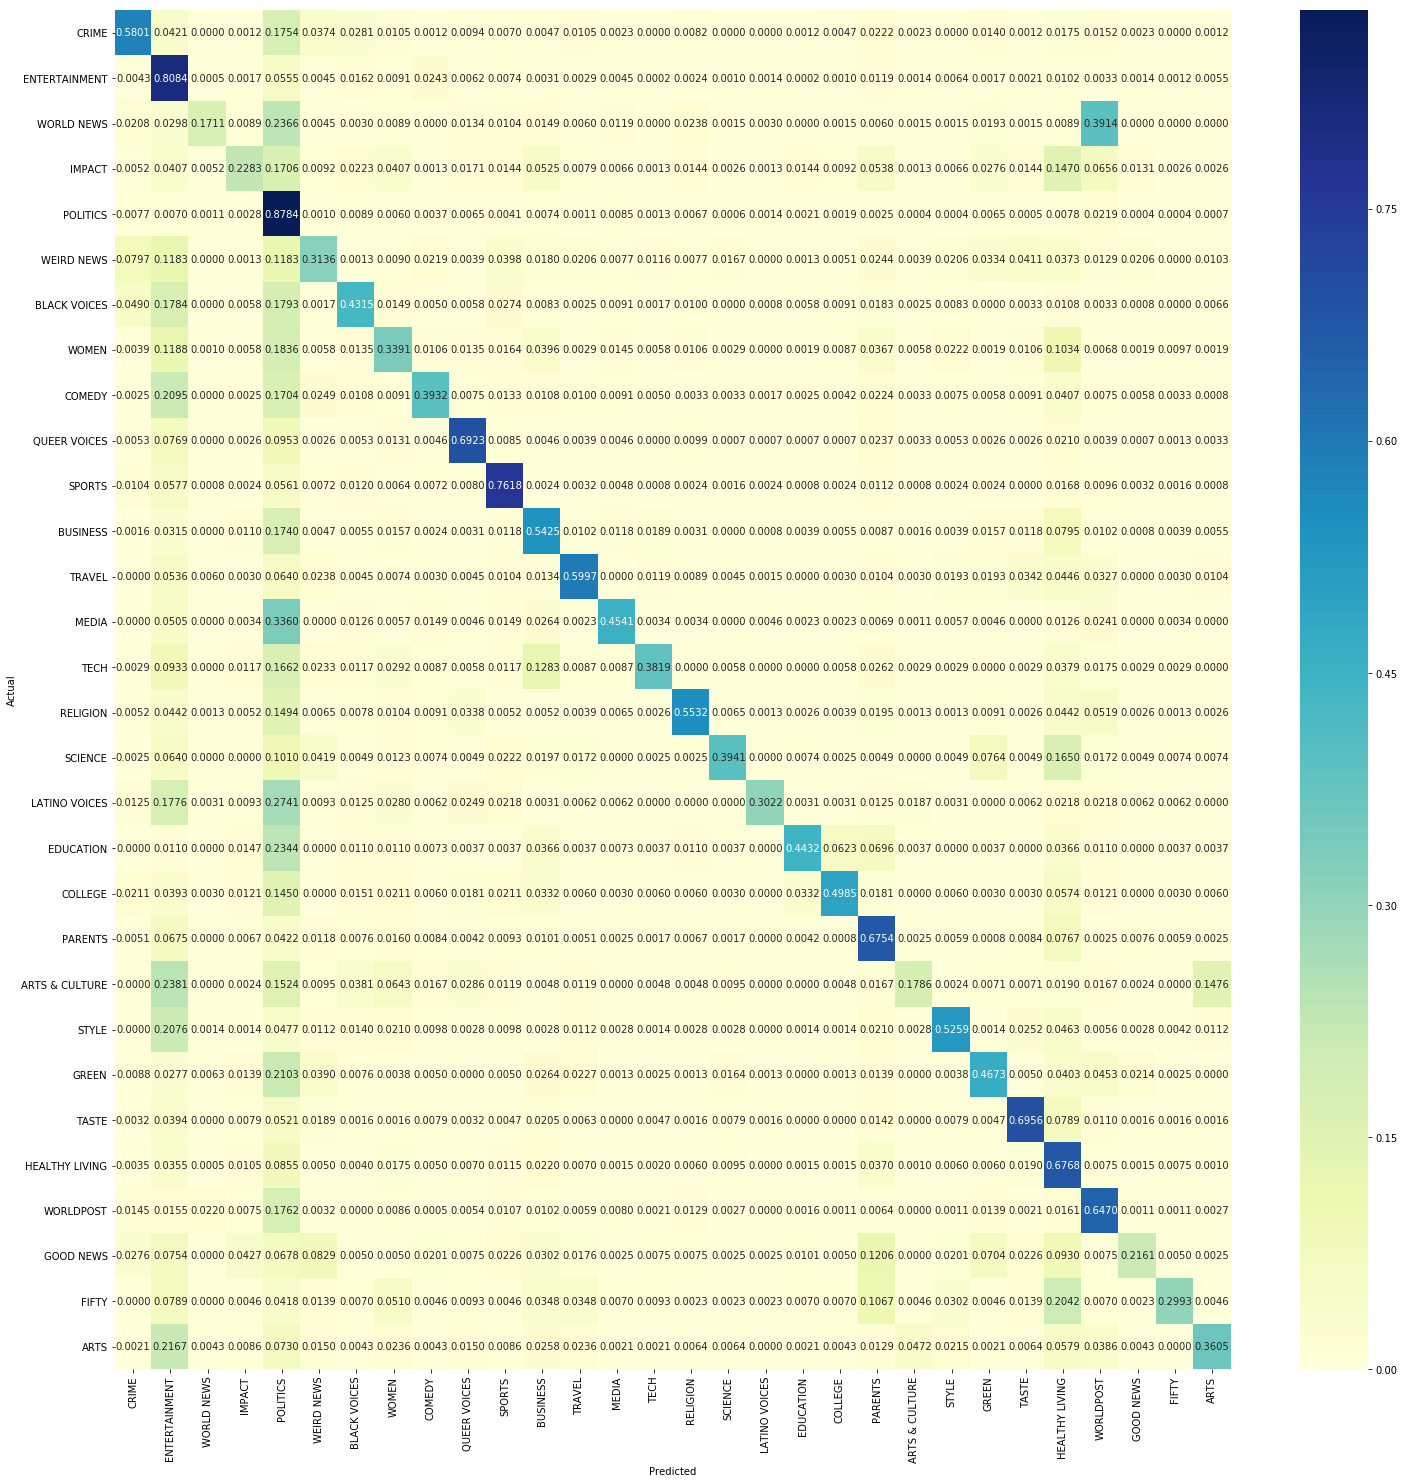


                precision    recall  f1-score   support

         CRIME       0.59      0.58      0.59       855
 ENTERTAINMENT       0.63      0.81      0.71      4197
    WORLD NEWS       0.60      0.17      0.27       672
        IMPACT       0.48      0.23      0.31       762
      POLITICS       0.71      0.88      0.79      9856
    WEIRD NEWS       0.44      0.31      0.37       778
  BLACK VOICES       0.60      0.43      0.50      1205
         WOMEN       0.45      0.34      0.39      1035
        COMEDY       0.63      0.39      0.48      1203
  QUEER VOICES       0.79      0.69      0.74      1521
        SPORTS       0.73      0.76      0.74      1247
      BUSINESS       0.58      0.54      0.56      1270
        TRAVEL       0.65      0.60      0.62       672
         MEDIA       0.63      0.45      0.53       872
          TECH       0.55      0.38      0.45       343
      RELIGION       0.64      0.55      0.59       770
       SCIENCE       0.61      0.39      0.48 

In [6]:
normalized_cm_report(LinearSVC(), df, X_train, X_test, y_train, y_test)

### Logistic Regression Classifier with TF-IDF

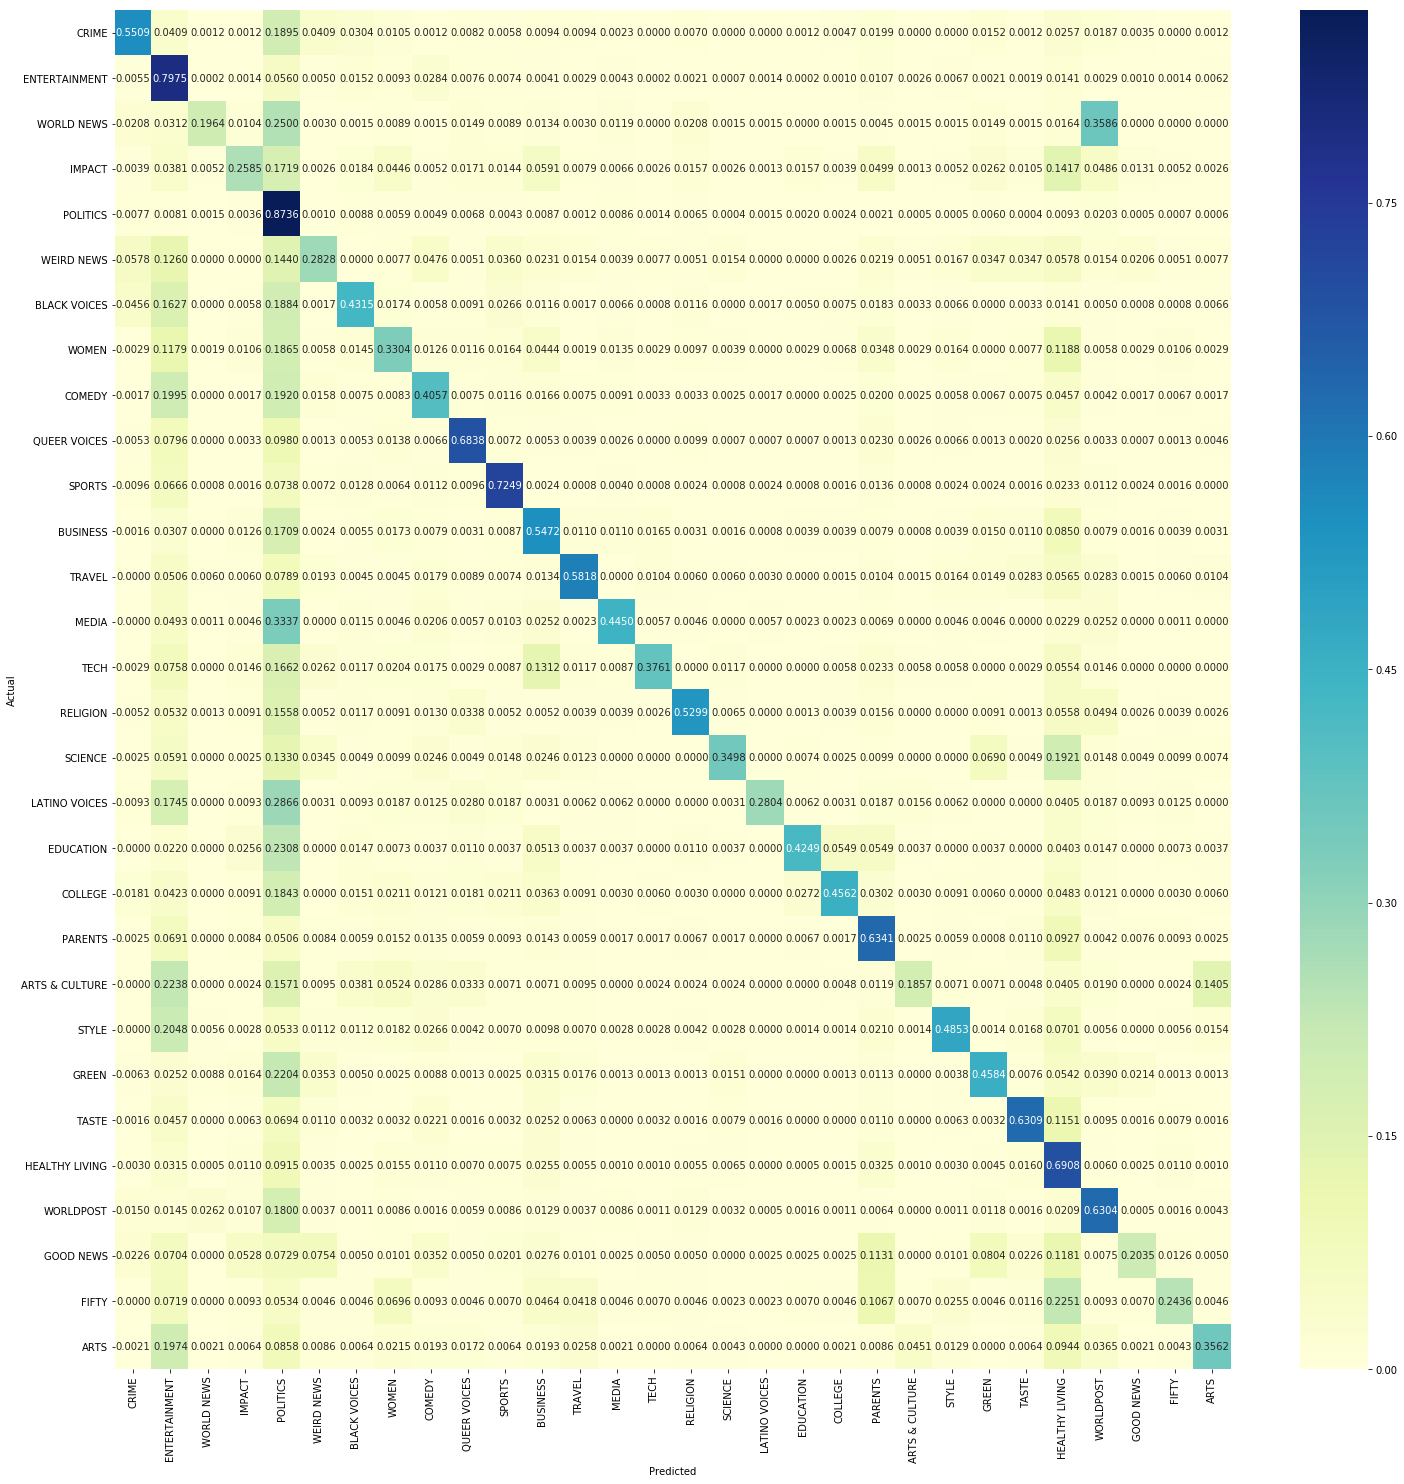


                precision    recall  f1-score   support

         CRIME       0.60      0.55      0.58       855
 ENTERTAINMENT       0.64      0.80      0.71      4197
    WORLD NEWS       0.59      0.20      0.29       672
        IMPACT       0.47      0.26      0.33       762
      POLITICS       0.70      0.87      0.78      9856
    WEIRD NEWS       0.46      0.28      0.35       778
  BLACK VOICES       0.61      0.43      0.50      1205
         WOMEN       0.45      0.33      0.38      1035
        COMEDY       0.52      0.41      0.46      1203
  QUEER VOICES       0.77      0.68      0.73      1521
        SPORTS       0.74      0.72      0.73      1247
      BUSINESS       0.55      0.55      0.55      1270
        TRAVEL       0.67      0.58      0.62       672
         MEDIA       0.64      0.44      0.53       872
          TECH       0.60      0.38      0.46       343
      RELIGION       0.64      0.53      0.58       770
       SCIENCE       0.61      0.35      0.44 

In [7]:
normalized_cm_report(LogisticRegression(C=1e5), df, X_train, X_test, y_train, y_test)

### Naive Bayes Classifier with TF-IDF

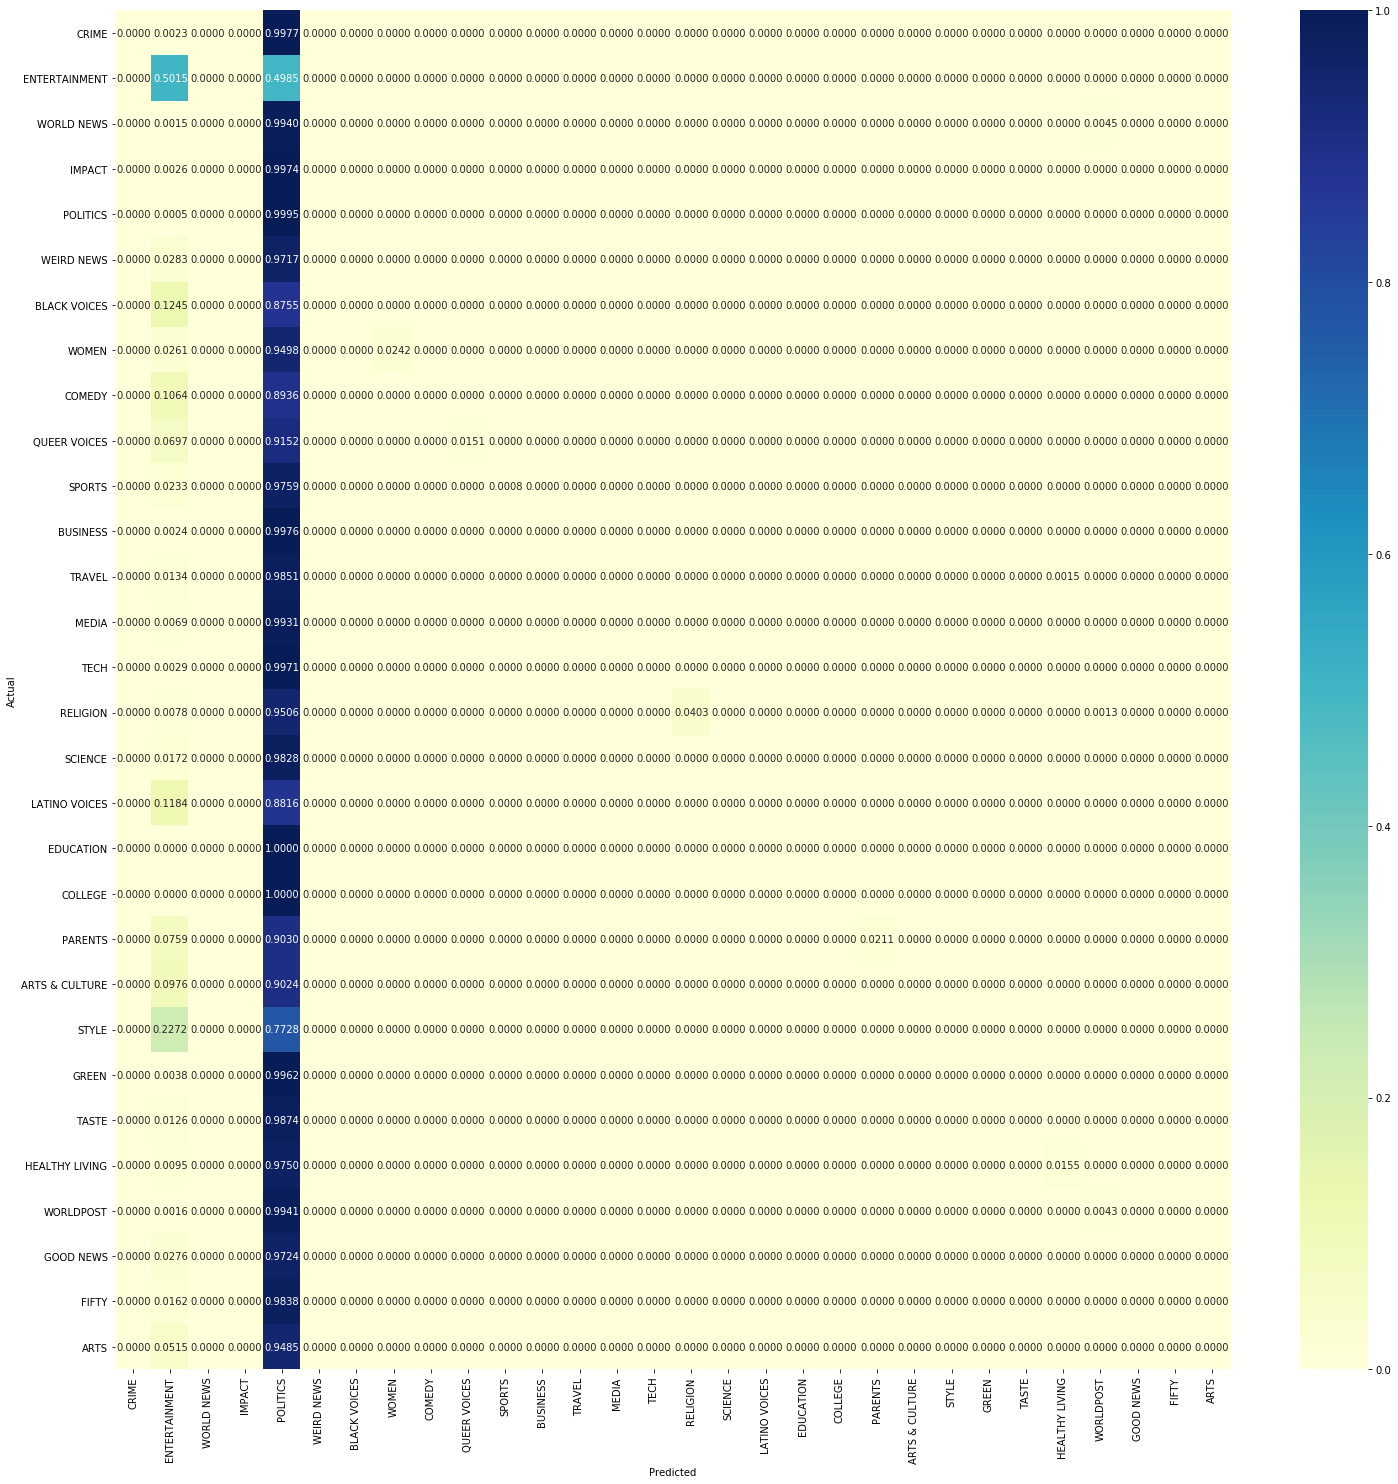


                precision    recall  f1-score   support

         CRIME       0.00      0.00      0.00       855
 ENTERTAINMENT       0.70      0.50      0.58      4197
    WORLD NEWS       0.00      0.00      0.00       672
        IMPACT       0.00      0.00      0.00       762
      POLITICS       0.29      1.00      0.45      9856
    WEIRD NEWS       0.00      0.00      0.00       778
  BLACK VOICES       0.00      0.00      0.00      1205
         WOMEN       1.00      0.02      0.05      1035
        COMEDY       0.00      0.00      0.00      1203
  QUEER VOICES       1.00      0.02      0.03      1521
        SPORTS       1.00      0.00      0.00      1247
      BUSINESS       0.00      0.00      0.00      1270
        TRAVEL       0.00      0.00      0.00       672
         MEDIA       0.00      0.00      0.00       872
          TECH       0.00      0.00      0.00       343
      RELIGION       1.00      0.04      0.08       770
       SCIENCE       0.00      0.00      0.00 

C:\Python3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [8]:
normalized_cm_report(MultinomialNB(), df, X_train, X_test, y_train, y_test)

# LSTM and CNN by Keras  

Next step is classifying the news articles using deep learning techniques. I implemented bosth LSTM and CNN as neural networks to classify the news. To establish word embeddings, I used the **'glove.6B.100d.txt'**, pre-trained GloVe word Embeddings file, from The Stanford Natural Language Processing Group (https://nlp.stanford.edu/data). You may need to download **glove.6B.zip** file and upzip it to save **'glove.6B.100d.txt'** in your working directory.  

## Preprocessing
- Remove stop words and abbreviation words from text data
- Create embedding matrix using pre-trained GloVe word embedding index (glove.6B.100d.txt)
- Match sentences length
- One-hot encoding of indexed-category variables

In [9]:
def clean_text(text):
       
    # remove stop words
    stops = set(stopwords.words("english"))
    
    text = text.lower().split() 
    text = [w for w in text if not w in stops]
    
    # remove word abbreviations
    text = " ".join(text)
    text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", text)    
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    
    return text


def get_coefs(word, *arr):
    
    return word, np.asarray(arr, dtype='float32')
    
def get_embedding_matrix(embedding_file, max_features, embed_dim):
    """
    return embedding matrix using embedding index
    """
    
    # word vectors
    embeddings_index = dict(get_coefs(*o.rstrip().rsplit(' ')) for o in open(embedding_file, encoding='utf8'))
    print('Found %s word vectors.' % len(embeddings_index))

    # embedding matrix
    vocabulary_size = 20000
    tokenizer = Tokenizer(num_words= vocabulary_size)
    tokenizer.fit_on_texts(df['text'])
    word_index = tokenizer.word_index
    num_words = min(max_features, len(word_index) + 1)
    
    # for random init
    all_embs = np.stack(embeddings_index.values()) 
    embedding_matrix = np.random.normal(all_embs.mean(), all_embs.std(), (num_words, embed_dim))
    for word, i in word_index.items():
        if i >= max_features:
            continue
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
        
    return embedding_matrix

In [10]:
# remove stop words and abbreviations
df['text'] = df['text'].map(lambda x: clean_text(x))

# find maximum number of words in texts
max_word_cnt = 0
for row in df.text:
    if len(row.split(" ")) > max_word_cnt:
        max_word_cnt = len(row.split(" ")) 

# tokenize text data and make them as indexed-sequences
vocabulary_size = 20000
tokenizer = Tokenizer(num_words= vocabulary_size)
tokenizer.fit_on_texts(df['text'])
sequences = tokenizer.texts_to_sequences(df['text'])

# match sentences length  
encorded_text = pad_sequences(sequences, maxlen = max_word_cnt)


# word vector dim
embed_dim = 100 
max_features = df.index[-1]

"""
In order to run the get_embedding_matrix function, 
you need to have the pre-trained GloVe word Embeddings file, 'glove.6B.100d.txt',  
from 'https://nlp.stanford.edu/data/'. Download 'glove.6B.zip' and unzip it.
Please save 'glove.6B.100d.txt' file to your current working directory.
"""
embedding_matrix = get_embedding_matrix('glove.6B.100d.txt', max_features, embed_dim)

Found 400000 word vectors.


In [11]:
# split into train and test data sets
X_train, X_test, y_train, y_test = train_test_split(encorded_text, df.category_idx, test_size=0.3, random_state=0)

# one-hot encoding
y_train = np_utils.to_categorical(y_train)

## LSTM + CNN

In [12]:
max_features = embedding_matrix.shape[0]

model = Sequential()
model.add(Embedding(max_features, embed_dim, input_length=X_train.shape[1], weights=[embedding_matrix], trainable=True))
model.add(Dropout(0.2))
model.add(Conv1D(256, 3, activation='relu'))
model.add(MaxPooling1D(pool_size=4))
model.add(LSTM(256))
model.add(Dense(30, activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
## Fit train data
model.fit(X_train, y_train, epochs=7, batch_size=512, validation_split=0.4)

Train on 52495 samples, validate on 34997 samples
Epoch 1/7
52495/52495 [==============================] - 219s 4ms/step - loss: 2.2122 - acc: 0.4073 - val_loss: 1.7380 - val_acc: 0.5190
Epoch 2/7
52495/52495 [==============================] - 222s 4ms/step - loss: 1.6262 - acc: 0.5386 - val_loss: 1.5443 - val_acc: 0.5674
Epoch 3/7
52495/52495 [==============================] - 220s 4ms/step - loss: 1.4334 - acc: 0.5877 - val_loss: 1.4427 - val_acc: 0.5897
Epoch 4/7
52495/52495 [==============================] - 220s 4ms/step - loss: 1.2961 - acc: 0.6208 - val_loss: 1.3988 - val_acc: 0.5994
Epoch 5/7
52495/52495 [==============================] - 220s 4ms/step - loss: 1.2003 - acc: 0.6471 - val_loss: 1.3769 - val_acc: 0.6054
Epoch 6/7
52495/52495 [==============================] - 220s 4ms/step - loss: 1.1045 - acc: 0.6718 - val_loss: 1.3785 - val_acc: 0.6041
Epoch 7/7
52495/52495 [==============================] - 220s 4ms/step - loss: 1.0232 - acc: 0.6945 - val_loss: 1.3631 - val_acc

---
I tired more than 10 epochs. Even if the training accuracy can be improved by increasing a number of epochs, accuracies on validation and test data would remain at 62%. In this code, I used 7 as the number of epochs.

In [13]:
# generate predicted categories of test data
pred_out = model.predict(X_test, batch_size=1)
y_pred = []
for i in range(len(pred_out)):
    idx = np.argmax(pred_out[i]) 
    y_pred.append(idx) 

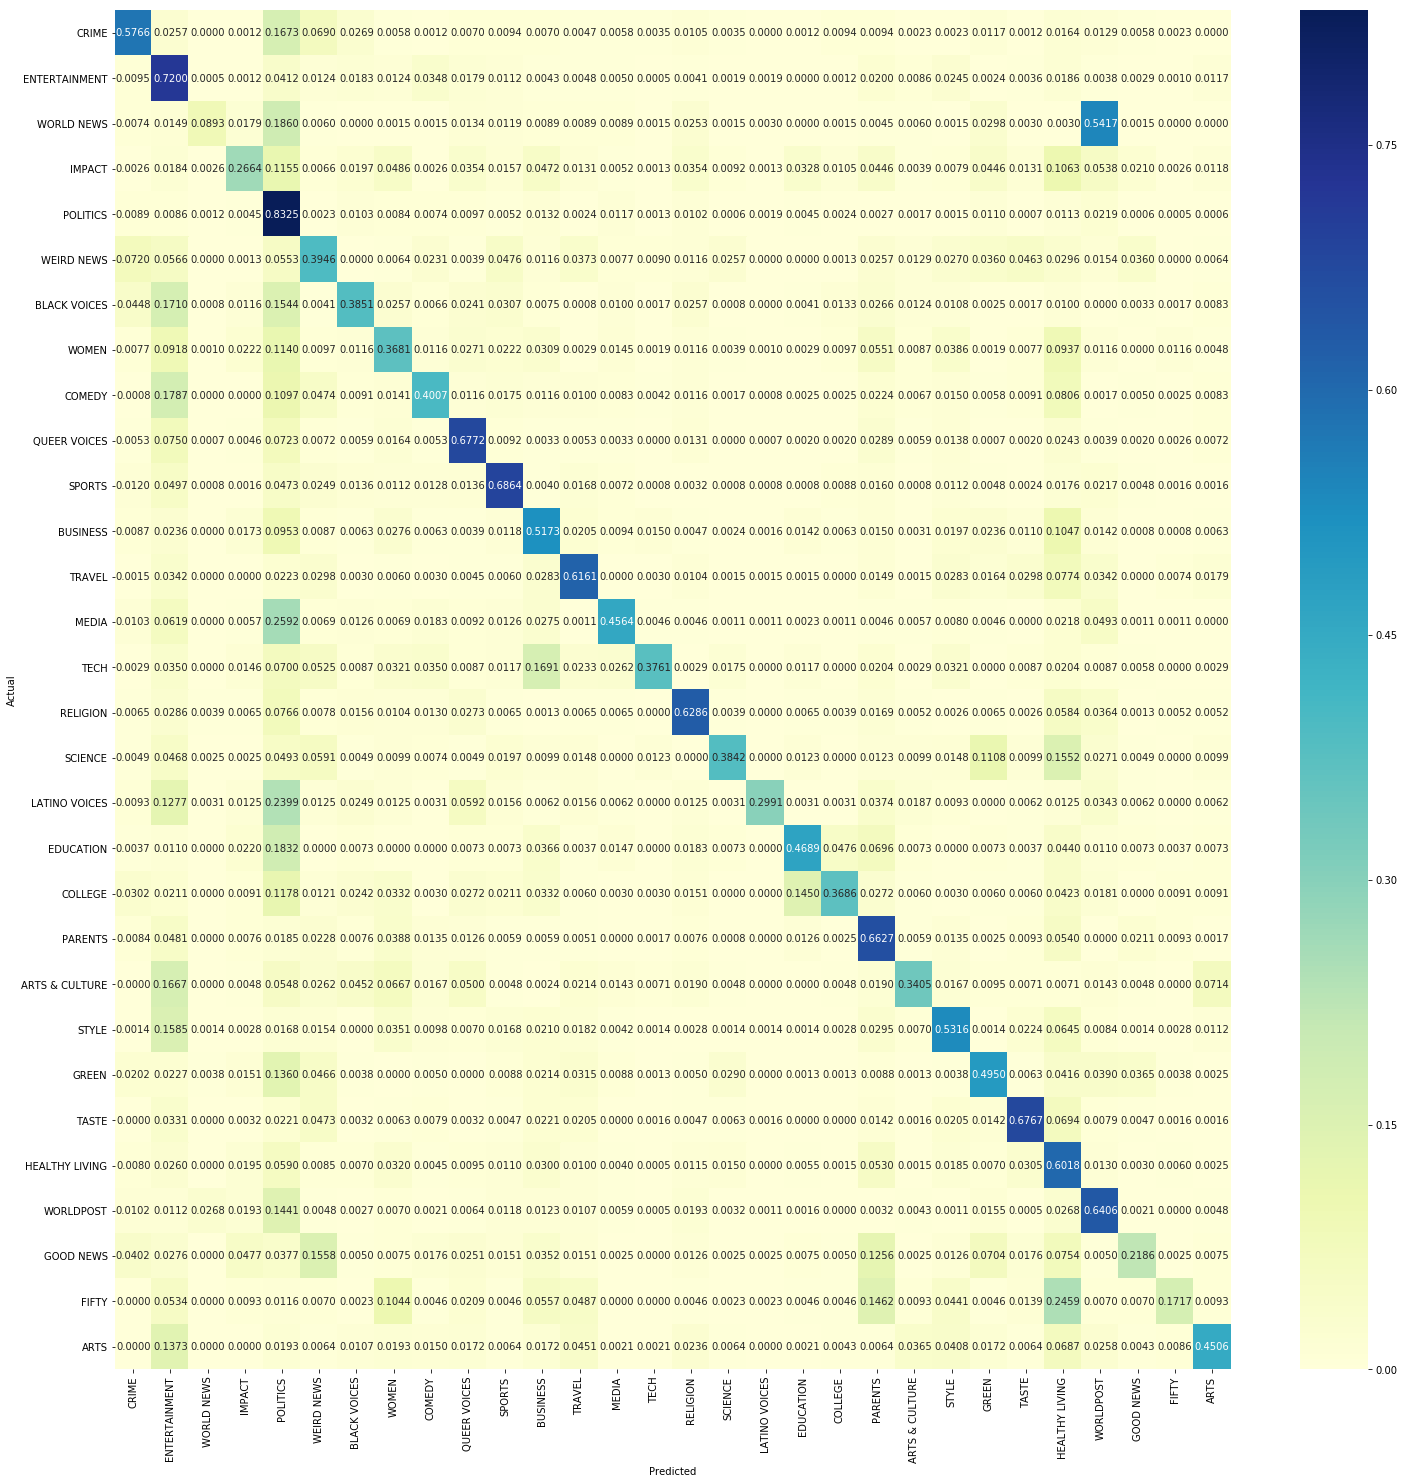


                precision    recall  f1-score   support

         CRIME       0.55      0.58      0.56       855
 ENTERTAINMENT       0.66      0.72      0.69      4197
    WORLD NEWS       0.43      0.09      0.15       672
        IMPACT       0.42      0.27      0.32       762
      POLITICS       0.77      0.83      0.80      9856
    WEIRD NEWS       0.35      0.39      0.37       778
  BLACK VOICES       0.55      0.39      0.45      1205
         WOMEN       0.39      0.37      0.38      1035
        COMEDY       0.54      0.40      0.46      1203
  QUEER VOICES       0.68      0.68      0.68      1521
        SPORTS       0.68      0.69      0.68      1247
      BUSINESS       0.53      0.52      0.52      1270
        TRAVEL       0.54      0.62      0.58       672
         MEDIA       0.59      0.46      0.51       872
          TECH       0.62      0.38      0.47       343
      RELIGION       0.55      0.63      0.59       770
       SCIENCE       0.52      0.38      0.44 

In [14]:
from sklearn.metrics import confusion_matrix

# nomalize confusion matrix
cm = confusion_matrix(y_test, y_pred)     
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

cats = df.category.unique()

# plot confusion matrix
plt.subplots(figsize=(25, 25))
sns.heatmap(cm, annot=True, fmt='.4f', cmap="YlGnBu", xticklabels = cats, yticklabels = cats)

plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

print()

# classification report: precision, recall, f1-score, support and accuracy
print(classification_report(y_test, y_pred, target_names = cats))
print("Prediction Accuracy on Test Data:", accuracy_score(y_test, y_pred))